# ノート 1: SEVIR データセット

### 目標: チュートリアルで使うデータセットに慣れる

### 背景

ML はデータセットから学習を行うため使用するデータセットについて理解しておくことが非常に重要です。
データにバイアスが含まれていると ML モデルに伝搬する可能性があるため、そのバイアスも理解している必要があります。
このノートではチュートリアルで使う [The Storm EVent ImagRy (SEVIR) dataset](https://proceedings.neurips.cc/paper/2020/file/fa78a16157fed00d7a80515818432169-Paper.pdf)
を可視化しながらデータセットへの理解を進めていきます。


### Step 1: インポート

実行に必要なパッケージをインポートしましょう。


In [1]:
import xarray as xr
import matplotlib.pyplot as plt

# ヘルパー関数
import sys

sys.path.insert(1, "../scripts/")
from aux_functions import show_vals, draw_zoom_window, get_right_units_vil

# 警告を表示しない
import warnings

warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = "retina"

### Step 2: データの読み込み

2017 年 8 月に発生したストームの事例から作成した netCDF4 形式のファイルを xarray を利用して読み込んでみましょう。


In [2]:
ds = xr.open_dataset("../datasets/sevir/onestorm.nc")
# 読み込んだ xarray.Dataset を print して内容を表示
ds

<xarray.Dataset>
Dimensions:            (x: 768, y: 768, t: 12, x2: 192, y2: 192, x3: 384,
                        y3: 384, x4: 48, y4: 48)
Dimensions without coordinates: x, y, t, x2, y2, x3, y3, x4, y4
Data variables:
    visible            (x, y, t) float32 ...
    water_vapor        (x2, y2, t) float32 ...
    clean_infrared     (x2, y2, t) float32 ...
    vil                (x3, y3, t) float32 ...
    lightning_flashes  (x4, y4, t) float32 ...
Attributes:
    t:        time dimension of all images. These are 5-min time steps
    x:        x pixel dimension of the visible imagery
    y:        y pixel dimension of the visible imagery
    x2:       x pixel dimension of the water vapor and infrared imagery
    y2:       y pixel dimension the water vapor and infrared imagery
    x3:       x pixel dimension of the vertically integrated liquid imagery
    y3:       y pixel dimension the vertically integrated liquid imagery
    x4:       x pixel dimension of the lightning flashes
    y4:       y pixel dimension of the lightning flashes

Data variables に表示されているものがデータセットに含まれるデータです。
5 つの変数が含まれていることが分かります。また各変数は異なる x,y 次元（x,x2,x3,x4）を持っています。
x,y の長さが異なるのは観測解像度が異なるためです。


### Step 3: 画像をプロットしよう

データセットに含まれる可視画像（`ds.visible`）を可視化してみましょう。
値は「反射係数（reference factor）」で$10^4$倍して整数にスケールして保存されています。
このため、$10^-4$倍してスケールを元の値に戻します。


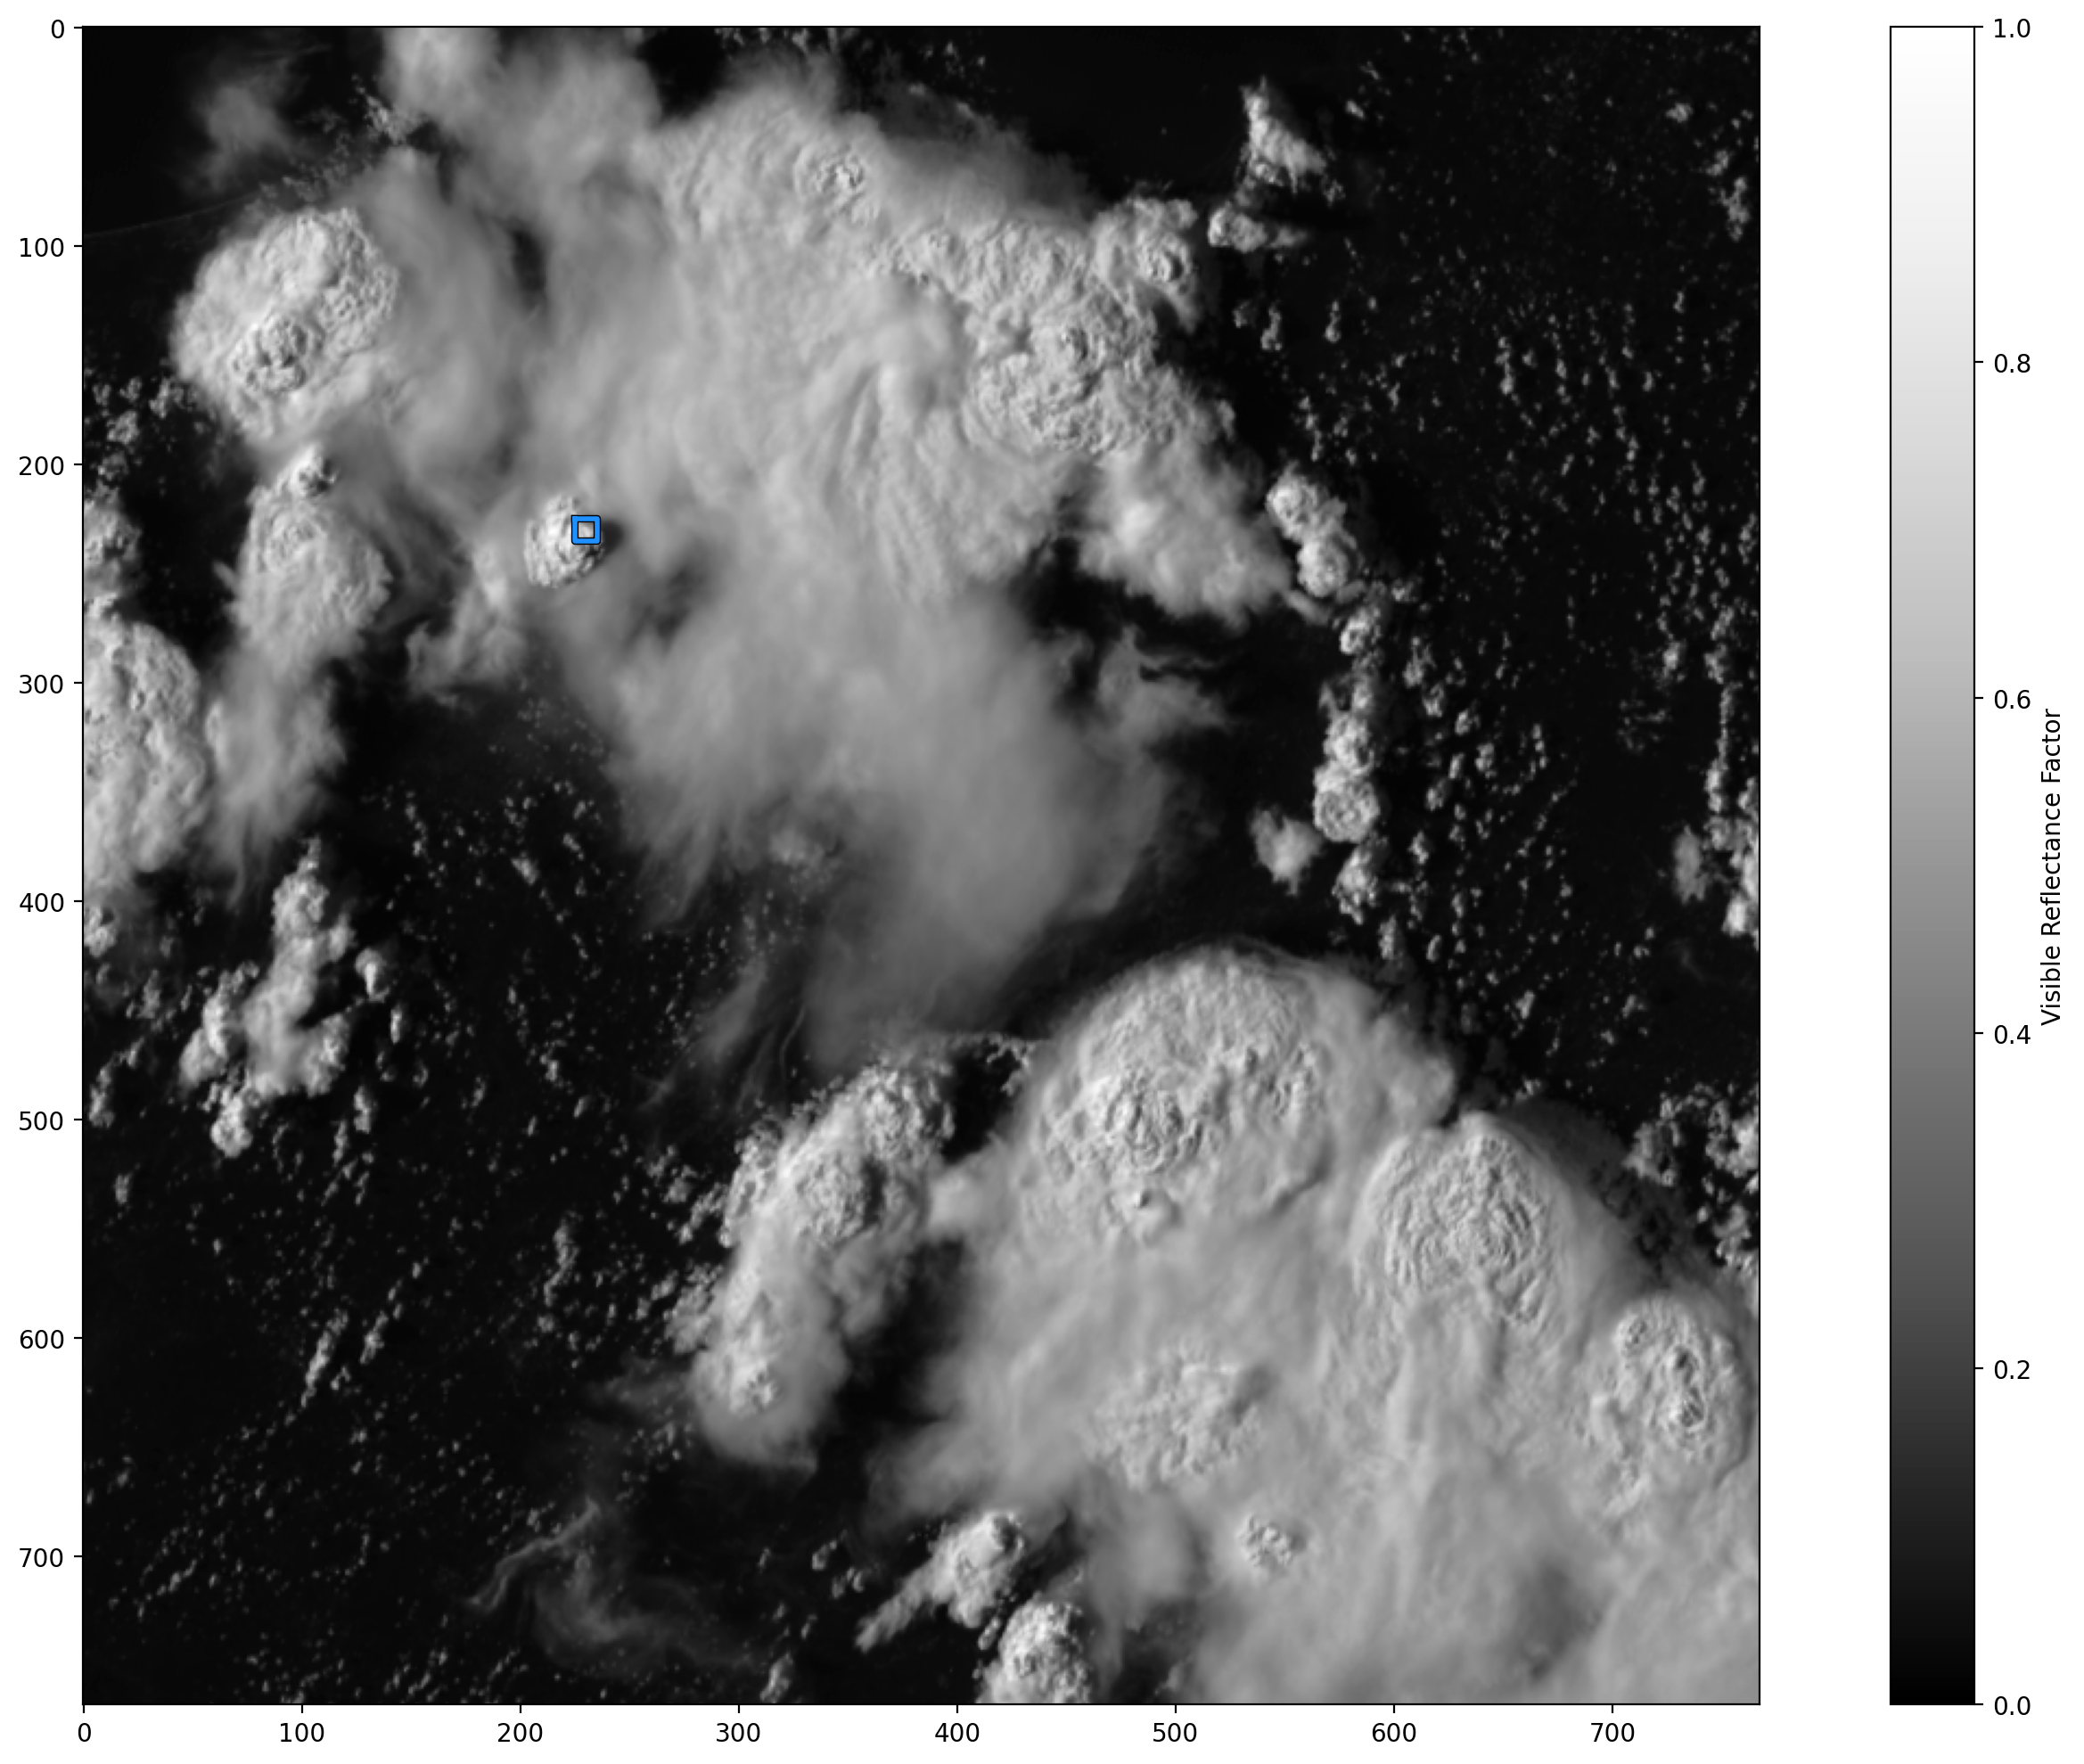

In [3]:
fig, ax = plt.subplots(figsize=(15, 10))
# t=0 の x, y ピクセルを描画します
mappable = ax.imshow(ds.visible[:, :, 0] * 1e-4, cmap="Greys_r", vmin=0, vmax=1)

# ヘルパー関数で四角形の領域を描画
# xzoom, yzoom は四角形の左上の座標（次のステップでこの部分を拡大する）
xzoom, yzoom = draw_zoom_window(ax, 225, 225)

fig.colorbar(mappable, label="Visible Reflectance Factor")
fig.tight_layout()

### Step 4: 領域を拡大してみよう

衛星画像はラスターデータです。つまり画像は値が割り当てられたピクセル（格子）が集まってできています。
プロットした衛星画像を拡大して細かく可視化してみましょう。


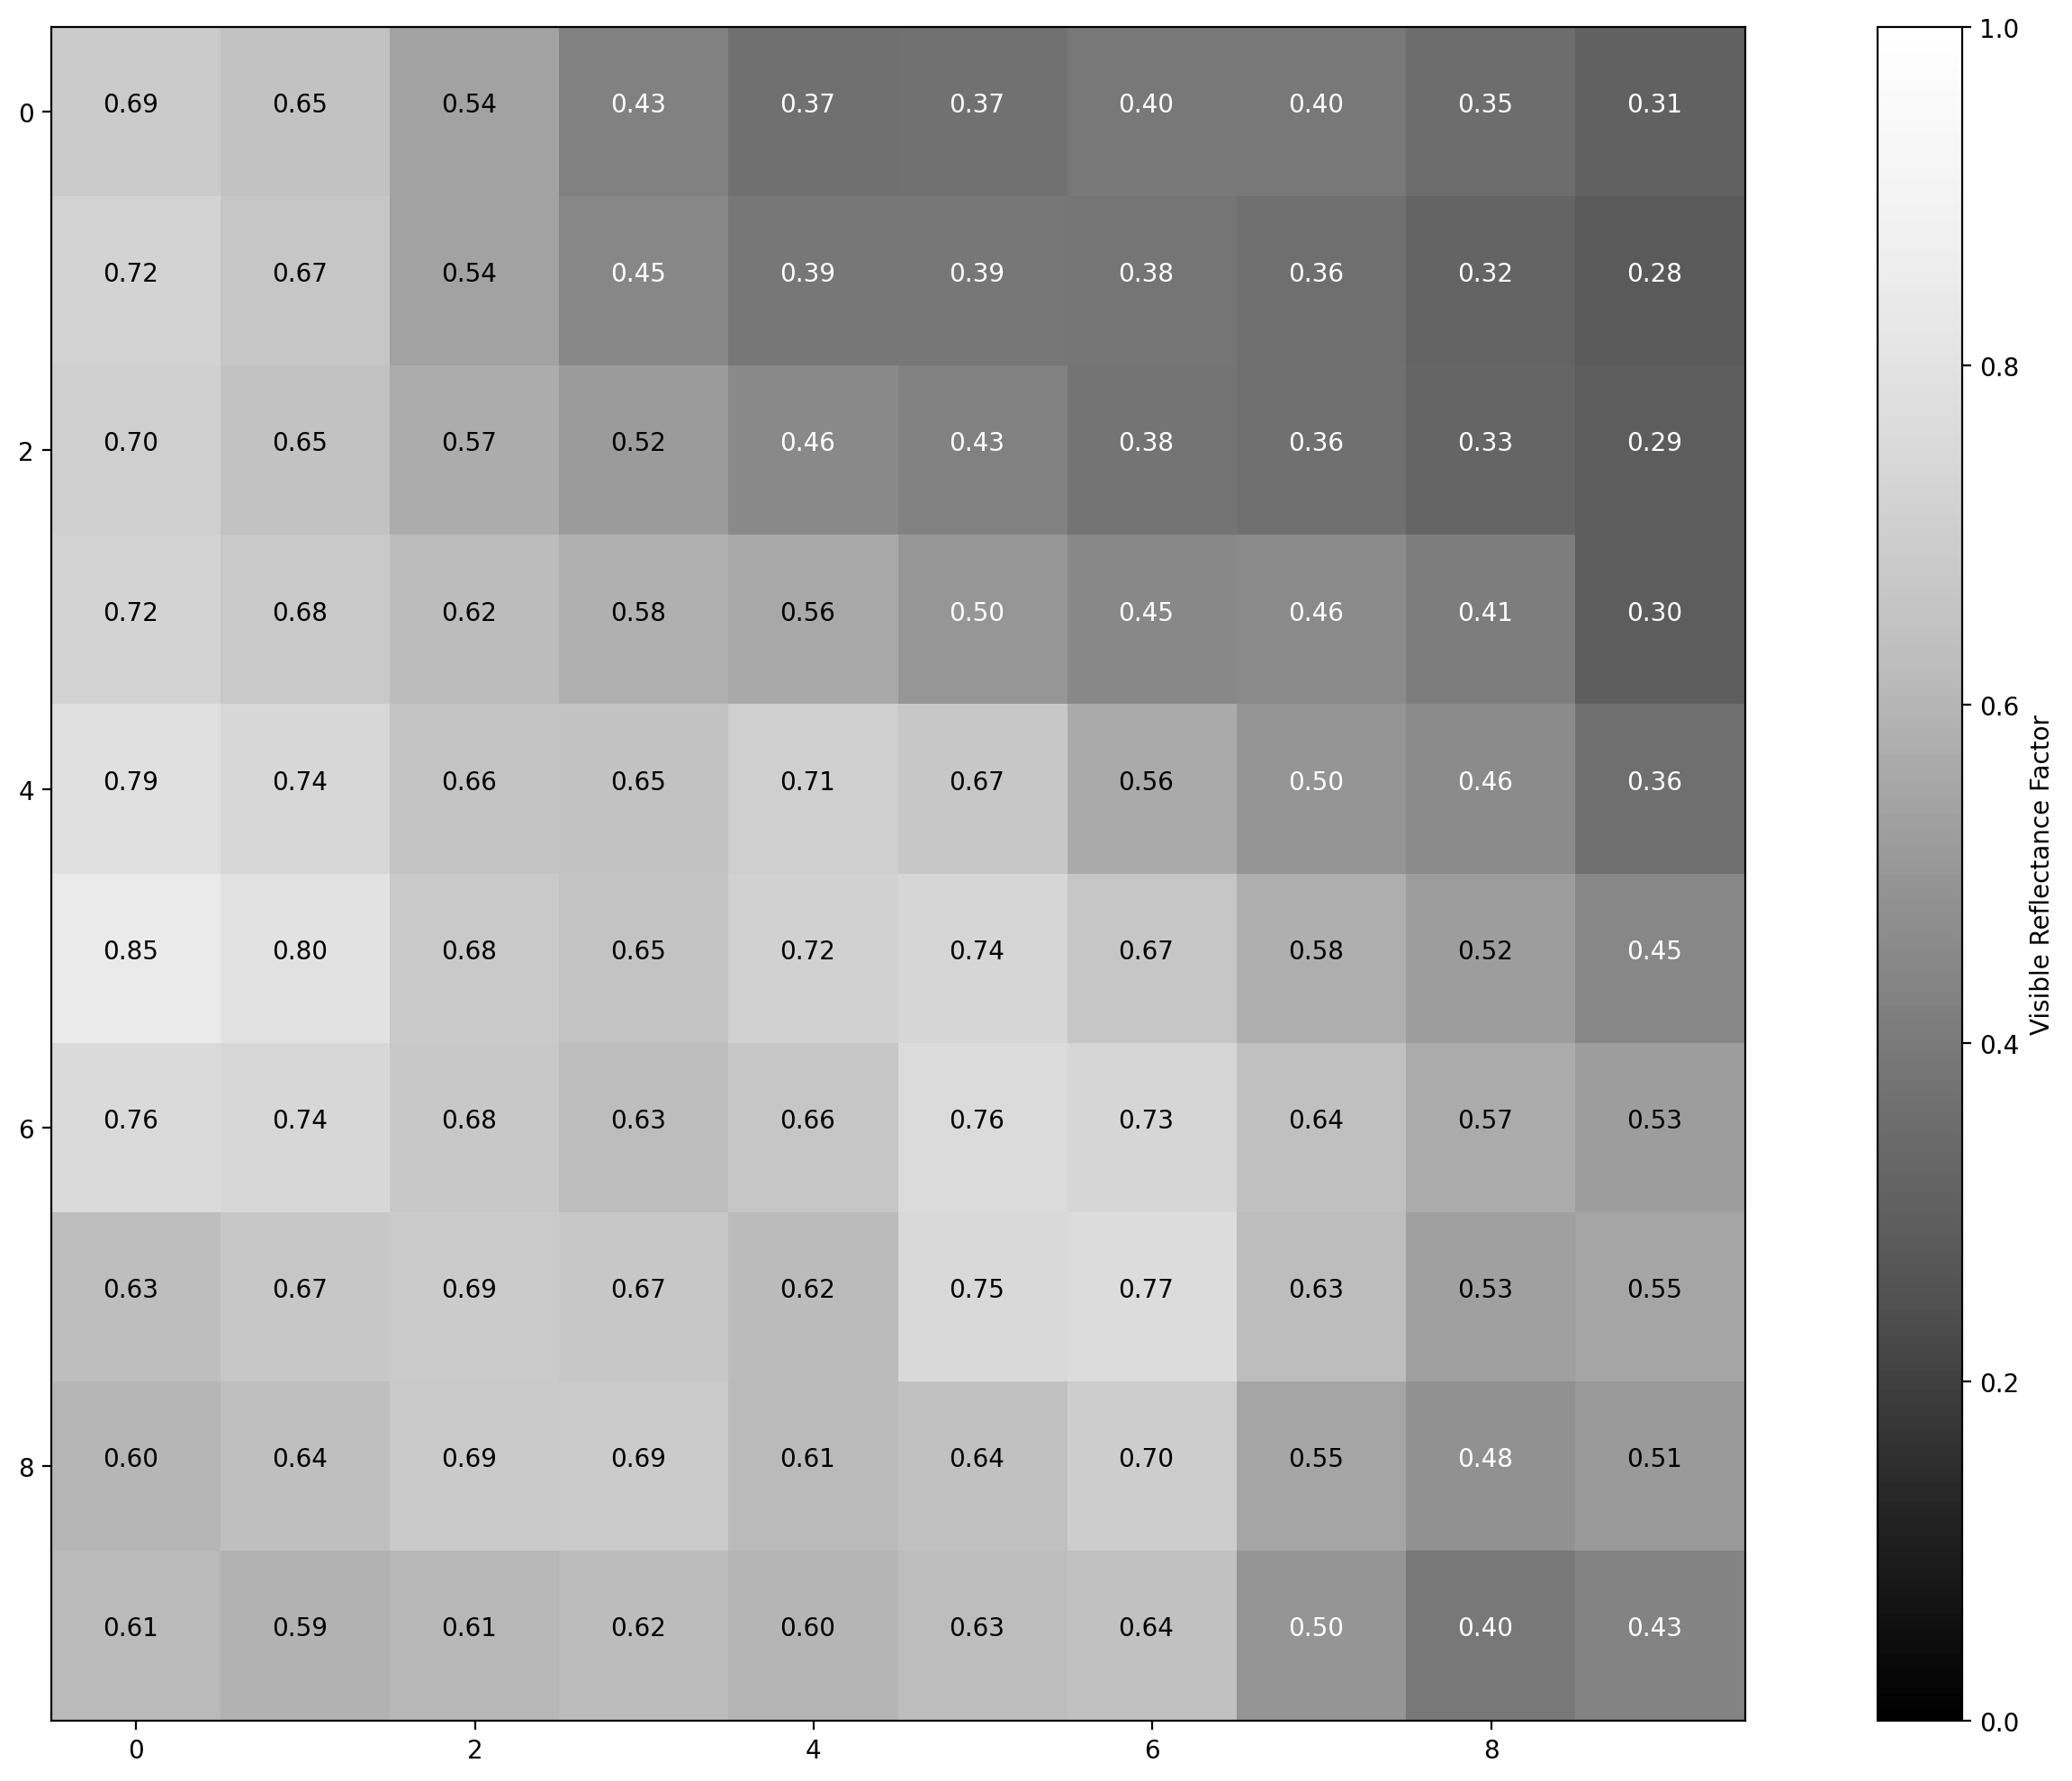

In [4]:
fig, ax = plt.subplots(figsize=(15, 10))
# xzoom, yzoom は1つ前にプロットした青枠の左下の x,y 座標
mappable = ax.imshow(
    ds.visible[xzoom : xzoom + 10, yzoom : yzoom + 10, 0] * 1e-4,
    cmap="Greys_r",
    vmin=0,
    vmax=1,
)
# ヘルパー関数で各ピクセルの値を描画
show_vals(ds.visible[xzoom : xzoom + 10, yzoom : yzoom + 10, 0] * 1e-4, ax=ax)

fig.colorbar(mappable, label="Visible Reflectance Factor")
fig.tight_layout()

ピクセルレベルまで拡大することで画像データの構造を理解できたと思います。
ML モデルの学習に使うにはこのような画像も数値的な特徴量として値を選び出し入力する必要があります。


### Step 5: 可視画像以外の全データをプロット

可視画像以外のすべてのデータも見てみましょう。論文の図 7 のような図を描画してみます。


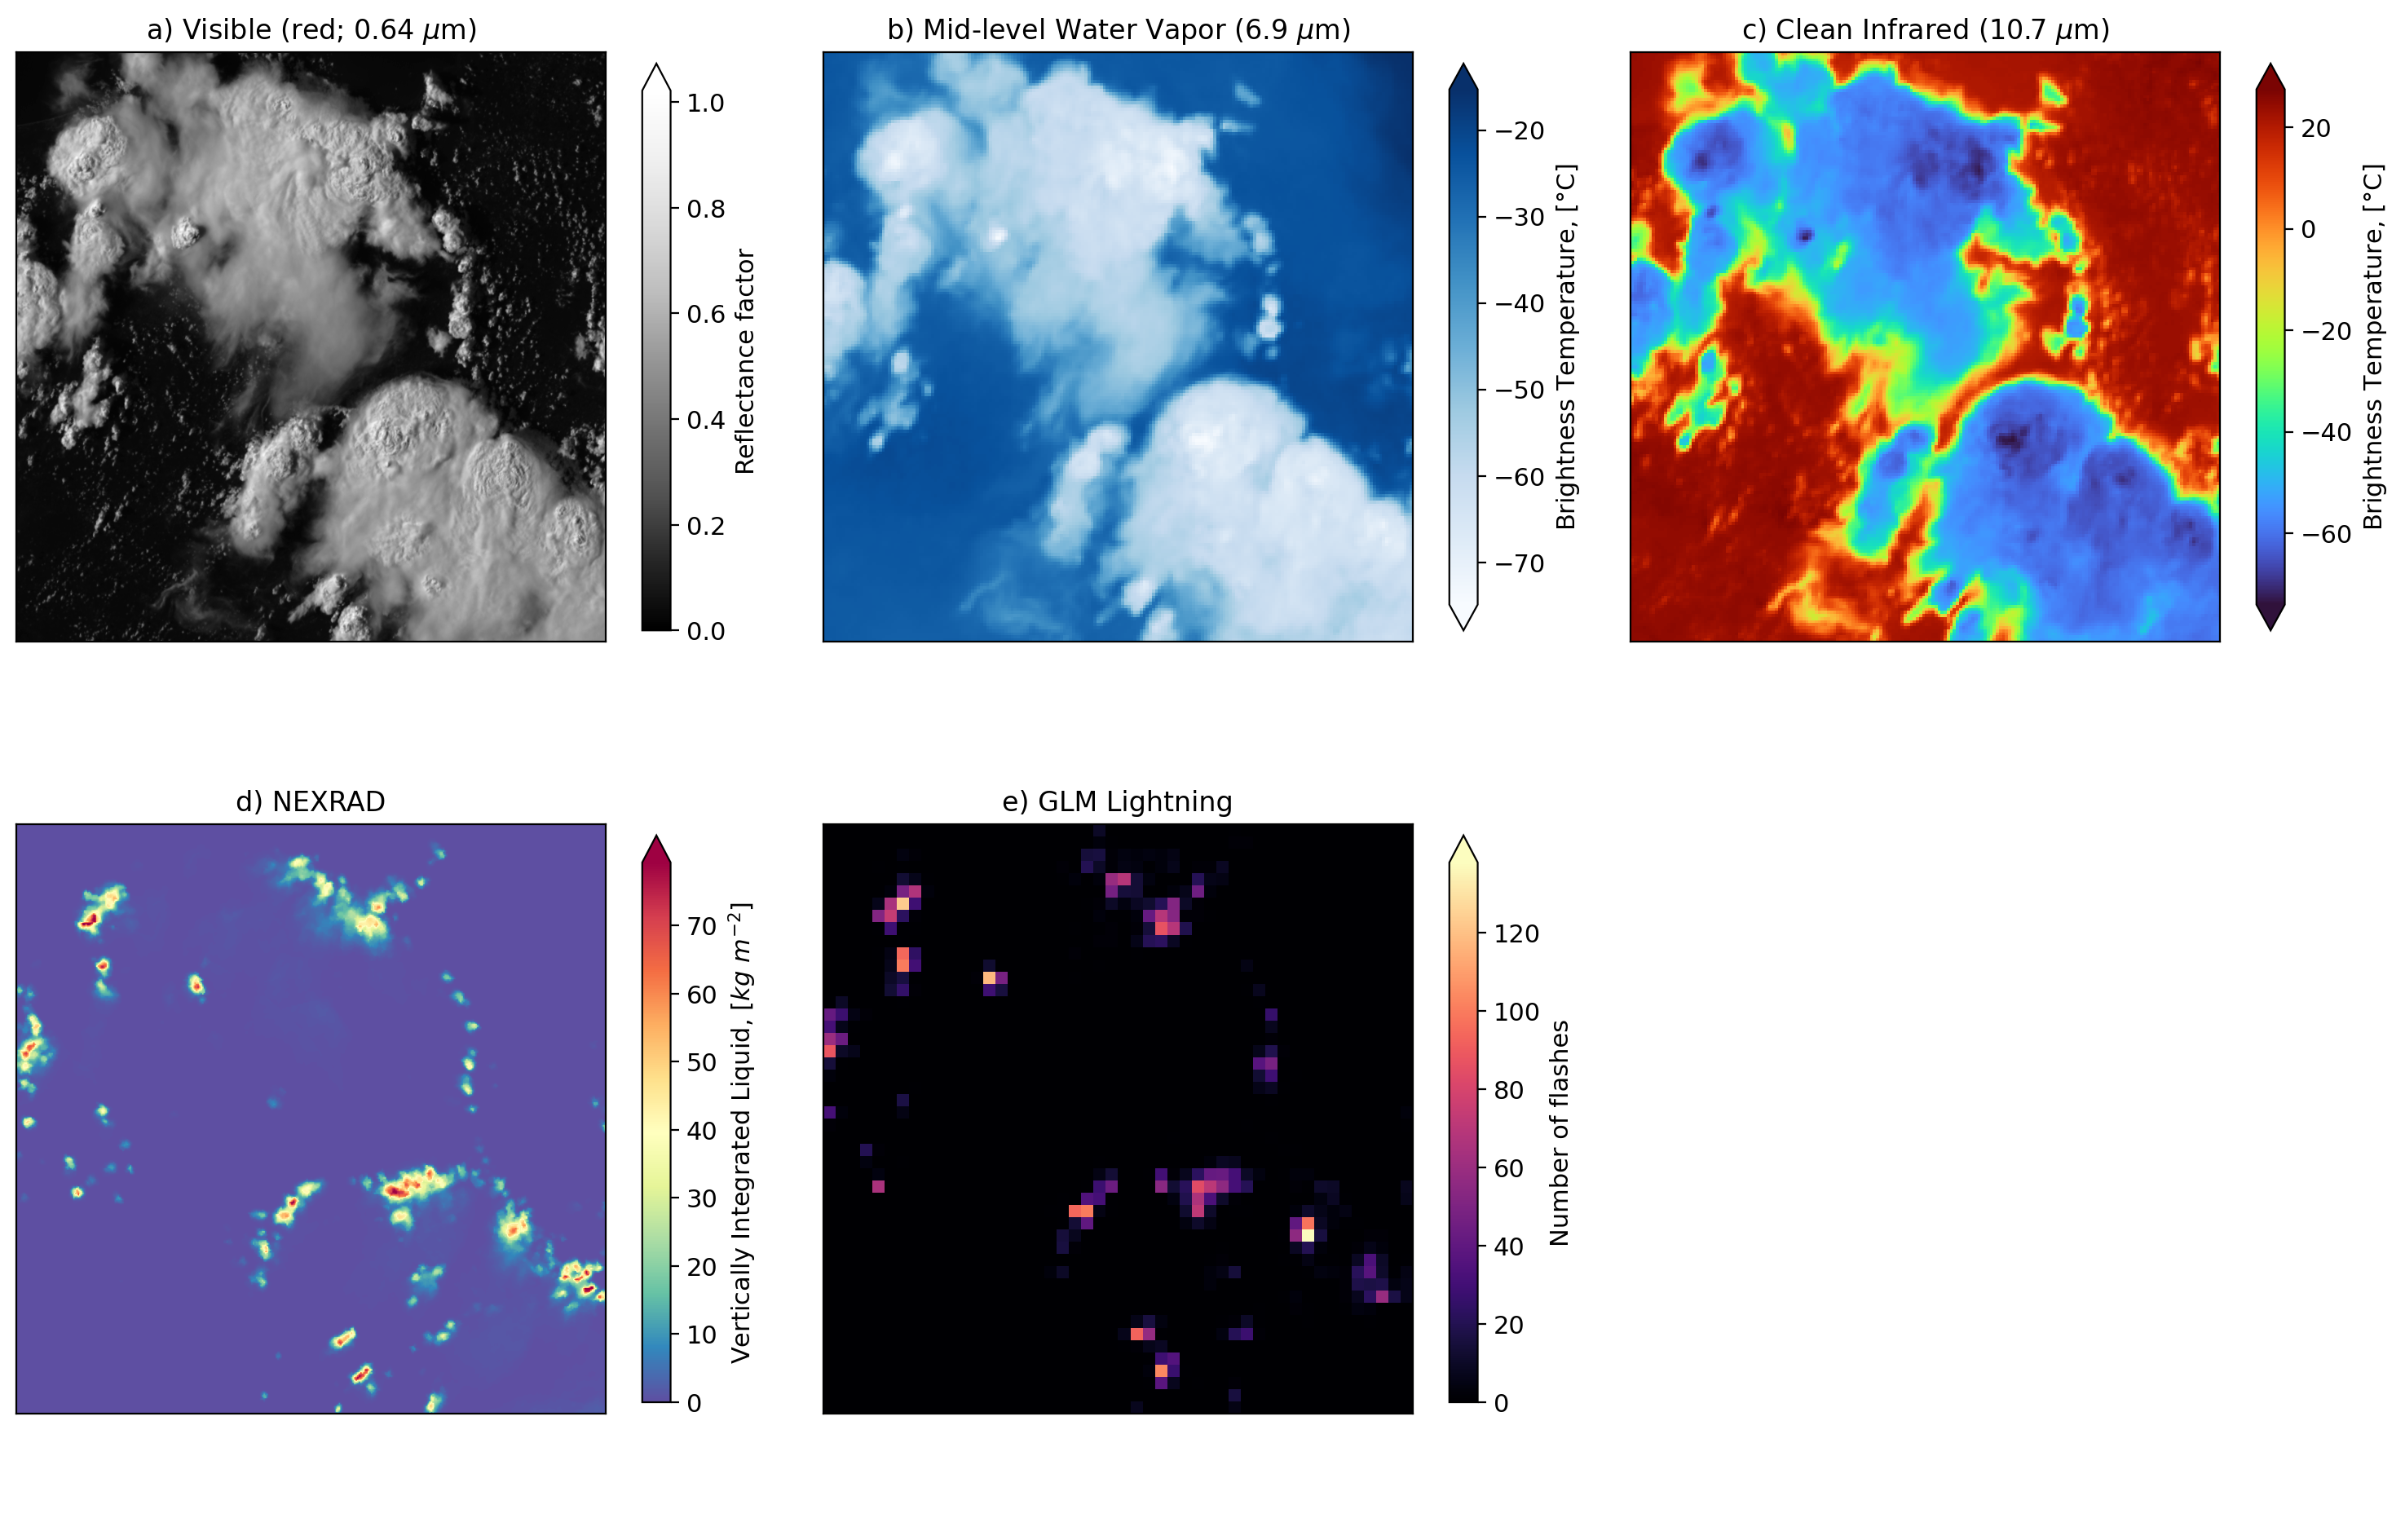

In [5]:
# 2行3列の描画枠をもつ図を作成
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
# 扱いやすいように axs を [2,3] の配列から [6,] の配列に変換
axs = axs.ravel()

# 描画する時間ステップ
frame_idx = 0

# 描画パラメータ
c_scale = 0.7  # カラーバーのデフォルトからの倍率
fs3 = 11  # フォントサイズ
fs4 = 18  # フォントサイズ
props = dict(boxstyle="square", facecolor="White", alpha=0.75)  # a),b),...の描画枠の描画オプション

############### subplot 1: 可視画像 ##################
ax = axs[0]
pm = ax.imshow(ds.visible[:, :, frame_idx] * 1e-4, cmap="Greys_r", vmin=0)
cbar = plt.colorbar(pm, ax=ax, shrink=c_scale, extend="max")
cbar.set_label("Reflectance factor", fontsize=fs3)
cbar.ax.tick_params(labelsize=fs3)
ax.set_title(r"a) Visible (red; 0.64 $\mu$m)")

############### subplot 2: 水蒸気画像 ###############
ax = axs[1]
pm = ax.imshow(ds.water_vapor[:, :, frame_idx] * 1e-2, cmap="Blues")
cbar = plt.colorbar(pm, ax=ax, shrink=c_scale, extend="both")
cbar.set_label(r"Brightness Temperature, [$\degree$C]", fontsize=fs3)
cbar.ax.tick_params(labelsize=fs3)
ax.set_title(r"b) Mid-level Water Vapor (6.9 $\mu$m)")

############### subplot 3: 赤外画像 ##################
ax = axs[2]
pm = ax.imshow(ds.clean_infrared[:, :, frame_idx] * 1e-2, cmap="turbo")
cbar = plt.colorbar(pm, ax=ax, shrink=c_scale, extend="both")
cbar.set_label(r"Brightness Temperature, [$\degree$C]", fontsize=fs3)
cbar.ax.tick_params(labelsize=fs3)
ax.set_title(r"c) Clean Infrared (10.7 $\mu$m)")

############### subplot 4: 鉛直積算水蒸気量（VIL）##################
ax = axs[3]
# VILを適切な単位に変換
vil = get_right_units_vil(ds.vil.values)
pm = ax.imshow(vil[:, :, frame_idx], cmap="Spectral_r", vmin=0)
cbar = plt.colorbar(pm, ax=ax, shrink=c_scale, extend="max")
cbar.set_label(r"Vertically Integrated Liquid, [$kg \ m^{-2}$]", fontsize=fs3)
cbar.ax.tick_params(labelsize=fs3)
ax.set_title("d) NEXRAD")

############### subplot 5: 雷（GLM Lightning Flashes）#############
ax = axs[4]
pm = ax.imshow(ds.lightning_flashes[:, :, frame_idx], cmap="magma")
cbar = plt.colorbar(pm, ax=ax, shrink=c_scale, extend="max")
cbar.set_label("Number of flashes", fontsize=fs3)
cbar.ax.tick_params(labelsize=fs3)
ax.set_title("e) GLM Lightning")

# 軸ラベルを非表示
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
# 6番目の枠を削除
axs[-1].axis("off")

# 余白の調整
fig.tight_layout()

### Step 6: 別の時間のデータをプロット

他のタイムステップもプロットしてみましょう。先ほどのコードの `frame_idx` を変えるだけです。


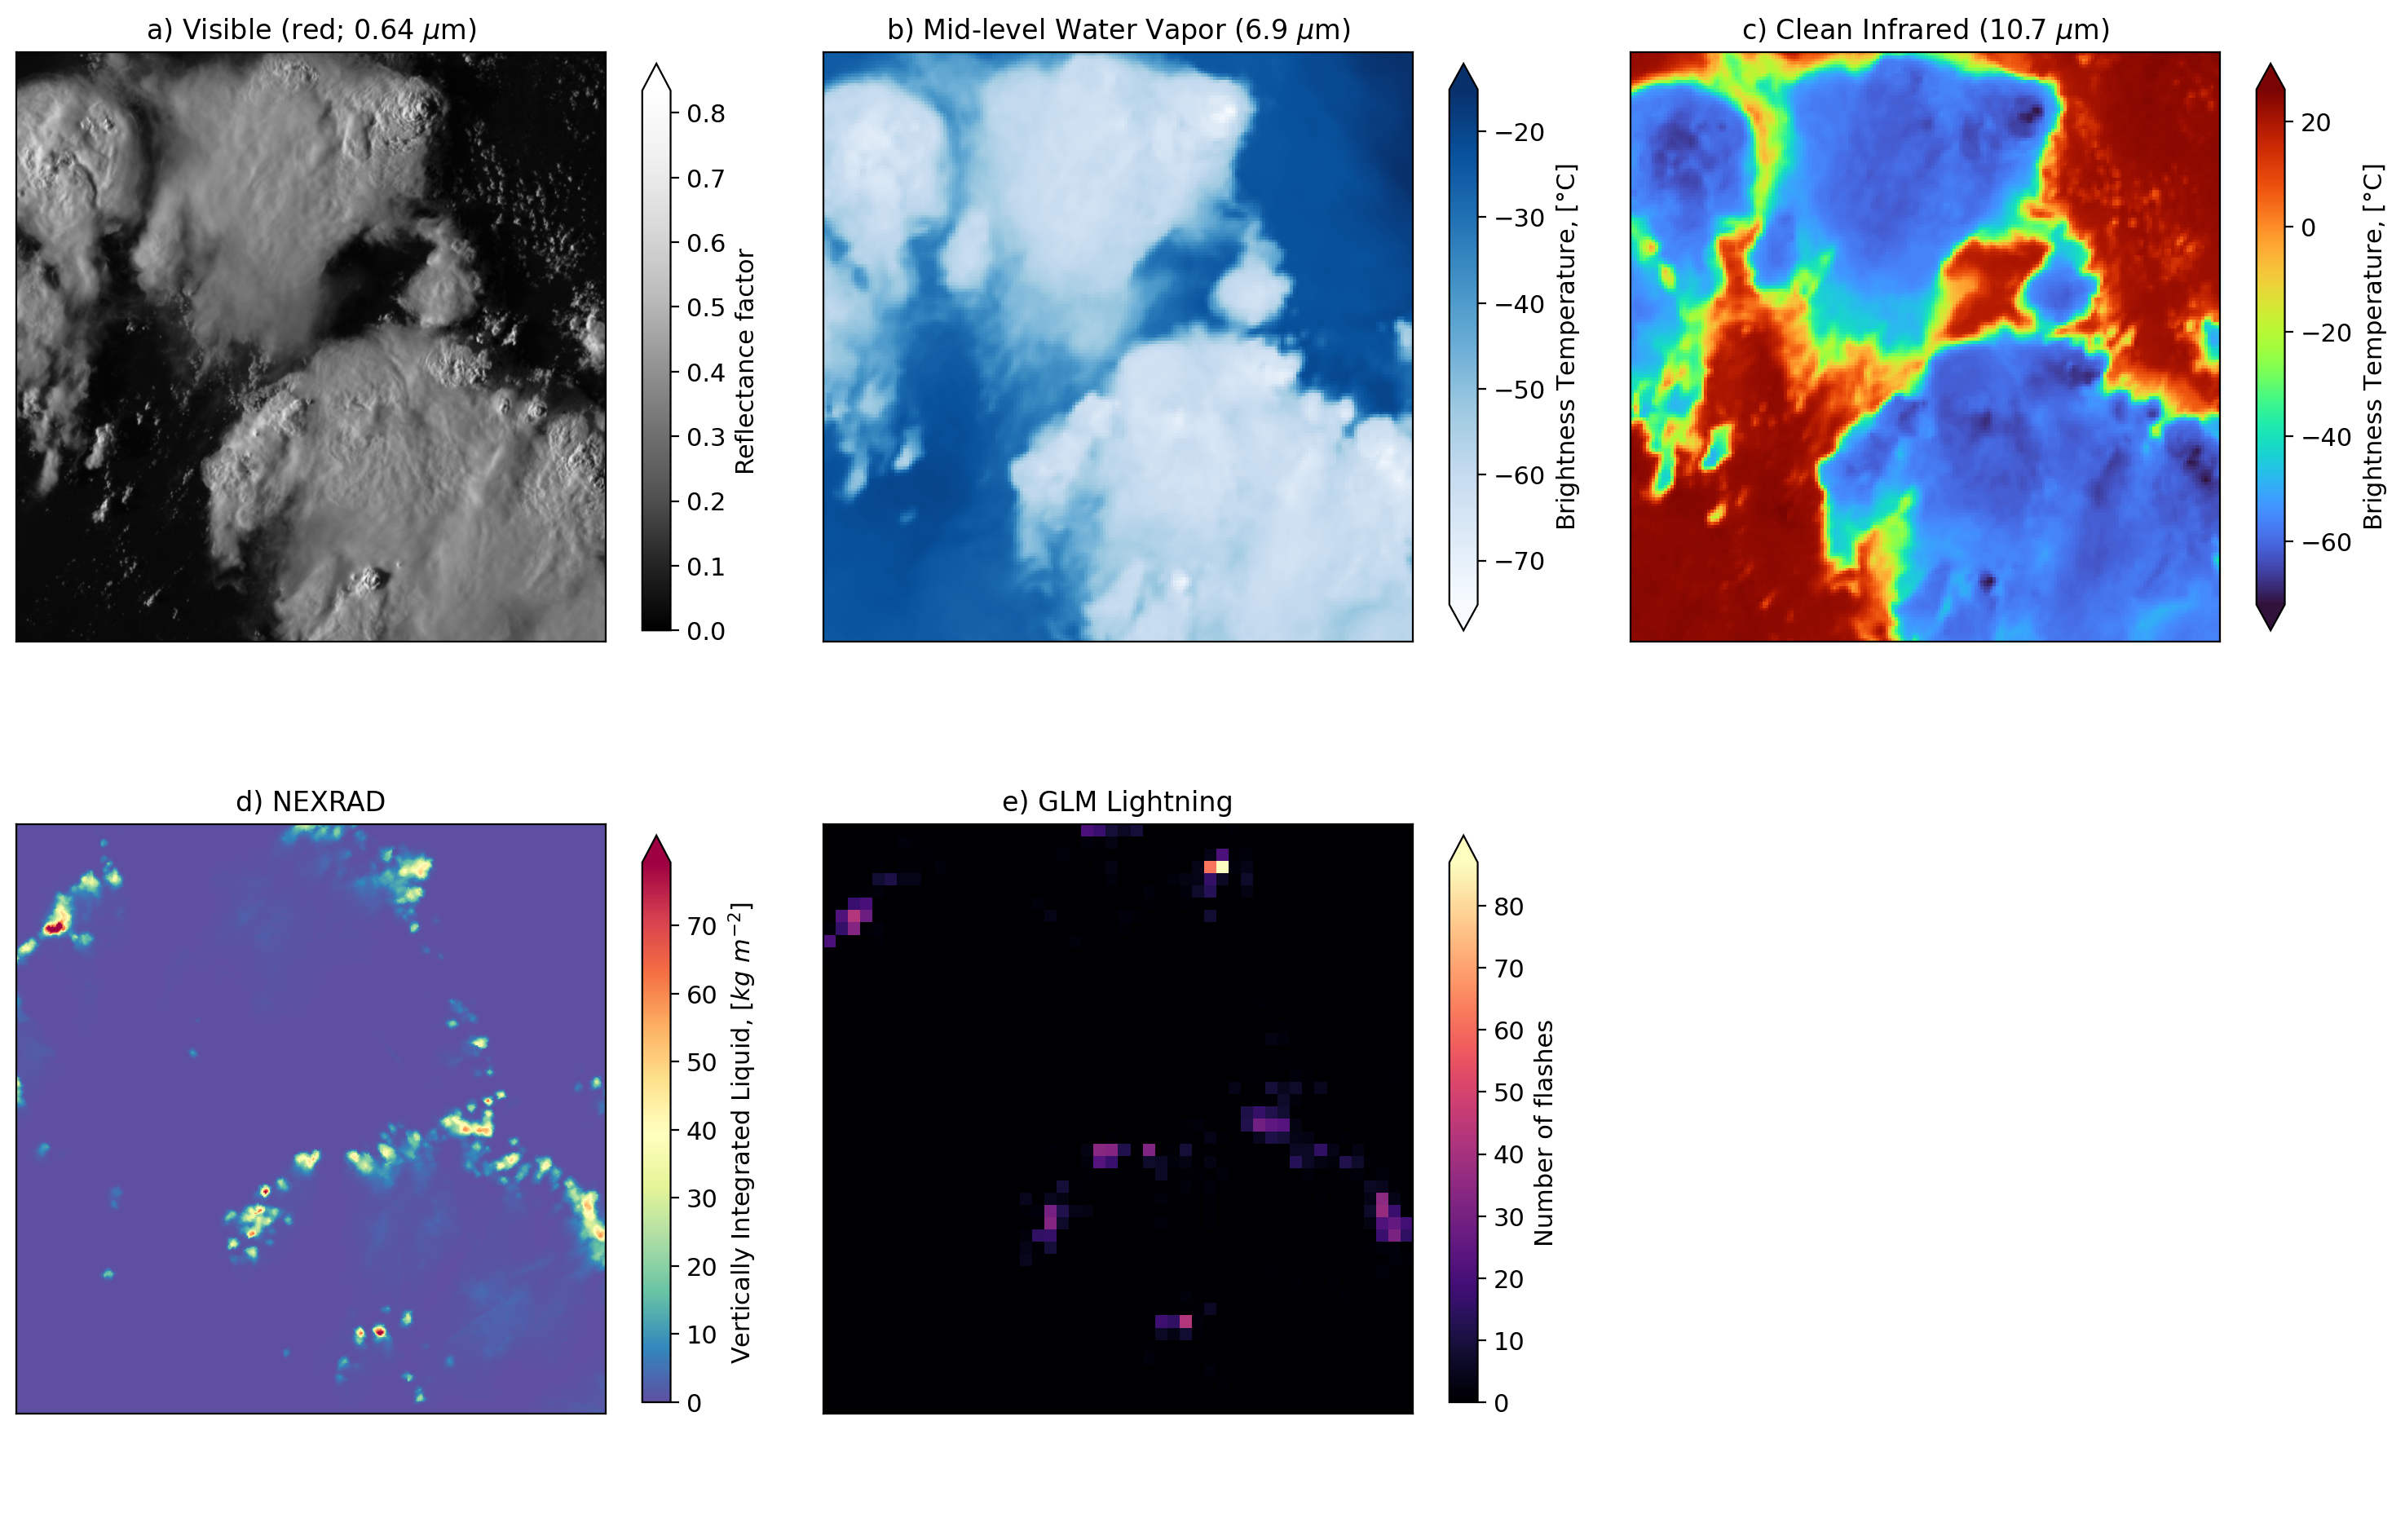

In [6]:
# 2行3列の描画枠をもつ図を作成
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
# 扱いやすいように axs を [2,3] の配列から [6,] の配列に変換します
axs = axs.ravel()

# 描画する時間ステップ
frame_idx = 11  # 0から11までのインデックスを変えてプロットを試してみましょう！

# 描画パラメータ
c_scale = 0.7  # カラーバーのデフォルトからの倍率
fs3 = 11  # フォントサイズ
fs4 = 18  # フォントサイズ
props = dict(boxstyle="square", facecolor="White", alpha=0.75)  # a),b),...の描画枠の描画オプション

############### subplot 1: 可視画像 ##################
ax = axs[0]
pm = ax.imshow(ds.visible[:, :, frame_idx] * 1e-4, cmap="Greys_r", vmin=0)
cbar = plt.colorbar(pm, ax=ax, shrink=c_scale, extend="max")
cbar.set_label("Reflectance factor", fontsize=fs3)
cbar.ax.tick_params(labelsize=fs3)
ax.set_title(r"a) Visible (red; 0.64 $\mu$m)")

############### subplot 2: 水蒸気画像 ###############
ax = axs[1]
pm = ax.imshow(ds.water_vapor[:, :, frame_idx] * 1e-2, cmap="Blues")
cbar = plt.colorbar(pm, ax=ax, shrink=c_scale, extend="both")
cbar.set_label(r"Brightness Temperature, [$\degree$C]", fontsize=fs3)
cbar.ax.tick_params(labelsize=fs3)
ax.set_title(r"b) Mid-level Water Vapor (6.9 $\mu$m)")

############### subplot 3: 赤外画像 ##################
ax = axs[2]
pm = ax.imshow(ds.clean_infrared[:, :, frame_idx] * 1e-2, cmap="turbo")
cbar = plt.colorbar(pm, ax=ax, shrink=c_scale, extend="both")
cbar.set_label(r"Brightness Temperature, [$\degree$C]", fontsize=fs3)
cbar.ax.tick_params(labelsize=fs3)
ax.set_title(r"c) Clean Infrared (10.7 $\mu$m)")

############### subplot 4: 鉛直積算水蒸気量（VIL）##################
ax = axs[3]
# VILを適切な単位に変換
vil = get_right_units_vil(ds.vil.values)
pm = ax.imshow(vil[:, :, frame_idx], cmap="Spectral_r", vmin=0)
cbar = plt.colorbar(pm, ax=ax, shrink=c_scale, extend="max")
cbar.set_label(r"Vertically Integrated Liquid, [$kg \ m^{-2}$]", fontsize=fs3)
cbar.ax.tick_params(labelsize=fs3)
ax.set_title("d) NEXRAD")

############### subplot 5: 雷（GLM Lightning Flashes）#############
ax = axs[4]
pm = ax.imshow(ds.lightning_flashes[:, :, frame_idx], cmap="magma")
cbar = plt.colorbar(pm, ax=ax, shrink=c_scale, extend="max")
cbar.set_label("Number of flashes", fontsize=fs3)
cbar.ax.tick_params(labelsize=fs3)
ax.set_title("e) GLM Lightning")

# 軸ラベルを非表示
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
# 6番目の枠を削除
axs[-1].axis("off")

# 余白の調整
fig.tight_layout()

SEVIR データセットの一部だけですが上手く可視化することができました。
このデータを活用して調査してみたい思った方は[SEVIR の論文](https://papers.nips.cc/paper/2020/hash/fa78a16157fed00d7a80515818432169-Abstract.html)
を読んでみることをお勧めします。

さあ、ノート 2 に進みましょう。
